# Quantum state preparation without coherent arithmetic

This notebook implements a quantum state preparation circuit based on _Quantum State Preparation Without Coherent Arithmetic_ ([arXiv:2210.14892](https://arxiv.org/pdf/2210.14892)), as part of “Implementation Challenge” by Classiq. 
 Specifically, we will construct a Gaussian state preparation circuit from [Classiq’s MIT iQuHack 2025 challenge](https://github.com/iQuHACK/2025-Classiq/blob/main/classiq_iQuHack_2025_final.ipynb) using the approach outlined in this paper.

$$|{x_0}\rangle_N = |0\rangle_N \rightarrow \sum_x {G(x)} |{x}\rangle_N$$

## Algorithm Overview

The algorithm leverages Quantum Eigenvalue Transformation (QET) technique to encode a function into a quantum state. 
The key idea is to approximate the desired function using polynomial approximations and implement these polynomials as quantum circuits.

#### General workflow
- The algorithm starts by defining a function $f(x)$ (in this case, a Gaussian function) to be encoded into the quantum state.
- It constructs a block-encoding circuit ($U_{\text{sin}}$) that initializes the input state.
- Using QET, the function $f(x)$ is applied to the input state via a circuit ($U_f$) that encodes the polynomial approximation of $f(x)$.
- Finally, amplitude amplification ($U_{\text{amp}}$) is applied to increase the probability of measuring the desired state.

#### Benefits
- Scalability: The algorithm avoids the need for coherent arithmetic, making it more efficient for amplitude encoding. It requires only a fixed number of ancillary qubits (at most 4) regardless of the function's complexity.
- Flexibility: It supports encoding various functions, such as polynomial or Fourier series approximations, and is applicable to a wide range of continuous functions.
- Resource Efficiency: By leveraging QET, the algorithm minimizes the number of non-Clifford gates and logical qubits while avoiding the use of amplitude oracles.

#### Complexity
- The complexity of the algorithm depends on the degree of the polynomial approximation used for `f(x)`. Higher-degree polynomials provide better approximations but require more quantum gates.
- Specifically, the non-Clifford gate complexity of the QET-based approach is approximately:
            $$ O\left(\frac{n \cdot d}{F}\right), $$
where:
    - $n$: Number of qubits representing the input state.
    - $d$: Degree of the polynomial approximation.
    - $F$: L2-norm filling-fraction of the polynomial approximation.

This complexity indicates that the number of non-Clifford gates scales linearly with the number of qubits $n$ and the polynomial degree $d$.
For detailed analysis, please refer to the paper.

## Implementation

To implement amplitude encoding without coherent arithmetic, we construct the following three components, as described in Figure 1 of the paper:
- $U_{\text{sin}}$: Block encoding of the initial values.
- $U_f$: Function application via Quantum Eigenvalue Transformation (QET).
- $U_{\text{amp}}$: Amplitude amplification to increase the probability of the target state.

For each component, we follow Section 2 of the paper. In constructing $U_f$, we determine the QET rotation angles using the classiq's `qsp` library functions . For evaluation, we verify correctness via state-vector simulation for small cases and perform resource estimation.

For Gaussian state preparation, we set `f(x)` to be the Gaussian function described in the[ MIT iQuHack 2025 challenge notebook](https://github.com/iQuHACK/2025-Classiq/blob/main/classiq_iQuHack_2025_final.ipynb).

In [1]:
!pip install -qq "classiq[qsp]"

In [2]:
# import all necessary modules
from typing import Dict

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm

import classiq
from classiq import *
from classiq.applications.qsp import qsp_approximate, qsvt_phases

print(classiq.__version__)

0.94.0


## 0. Set Parameters for Gaussian State Preparation

We define the parameters for the Gaussian state, including the truncation value, decay rate, number of qubits, and the Gaussian function.

In [3]:
# Parameters for Gaussian amplitude
TRUNCATION_VALUE = 2  # truncation value of the Gaussian
MIN_X = -TRUNCATION_VALUE  # min x
MAX_X = TRUNCATION_VALUE  # max x
EXP_RATE = 1  # decay rate of the Gaussian
F = lambda x: np.exp(-EXP_RATE * (x**2))  # Gaussian function

# Resolution of input x
NUM_QUBITS = 8

## 1. Define $U_{\text{sin}}$ circuit

To prepare the target state, we first need to define $U_{\text{sin}}$ such that:

$$
U_{\text{sin}} |{x}\rangle_n |{0}\rangle_a = |{x}\rangle_n (\sin(x/N)|{0}\rangle_a + \cos(x/N)|{1}\rangle_a)
$$

where $n$ is the number of qubits used to represent the state, $a$ is the ancillary qubit, and $N=2^n$ is the number of possible states. 

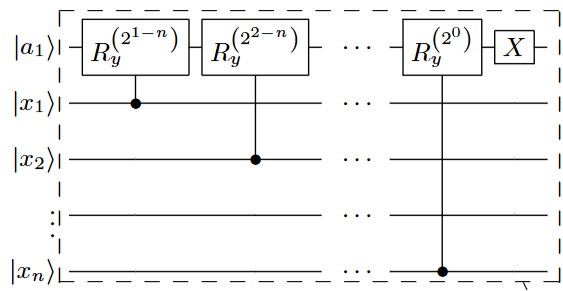

The circuit above shows $U_{\text{sin}}$ (Fig. 1a in the paper). It is implemented as follows:

In [4]:
@qfunc
def u_sin(x: QArray[QBit], a: QBit) -> None:
    repeat(
        count=x.len,
        iteration=lambda i: CRY(theta=2 ** (-x.len + i + 1), ctrl=x[i], target=a),
    )
    X(a)

## 2. Define $U_{\tilde{f}}$ circuit

Then by combining the $U_{\text{sin}}$ circuit with the QSVT technique, we can define the circuit $U_{\tilde{f}}$ that applies the given function $f$ to the state $|{x}\rangle_n$ such that
$$
U_{\tilde{f}} |{+}\rangle^{\otimes{n}}|{000}\rangle_a = c_{0} |{\Psi_{\tilde{f}}}\rangle|{000}\rangle_a + ...
$$
where $\tilde{f}$ is the approximation of the function $f$, $|{\Psi_{\tilde{f}}}\rangle$ is the state after applying the function, and $c_{0}$ is the coefficient of the desired state with $|{000}\rangle_a$.

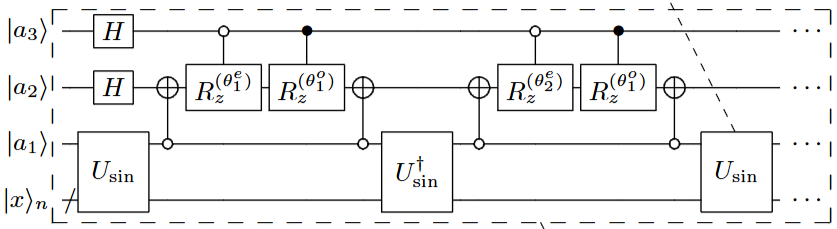

The circuit above shows $U_{\tilde{f}}$ (Fig. 1b in the paper). 
We will implement this circuit using the QSVT technique, which allows us to apply the function $f$ to the input block encoding circuit $U_{\text{sin}}$.

As shown in S2 in the paper, the function we seek to implement using QSVT is the scaled version of 
$$
h(y) = f((b-a)\arcsin(y)+a)
$$
over the domain $y \in [0, \sin(1)]$.
This is defined as `POLY_FUNC` in the code below.

In [5]:
def h(f, a, b):
    """
    Eq. (3) in https://arxiv.org/pdf/2210.14892
    """
    return lambda y: f((b - a) * np.arcsin(y) + a)


def h_hat(h, h_max):
    """
    Eq. (4) in https://arxiv.org/pdf/2210.14892

    The scaled version of the function h(y).
    """
    return lambda y: h(y) / h_max


# Scaled function definition following the paper
H_FUNC = h(f=F, a=MIN_X, b=MAX_X)
POLY_FUNC = h_hat(h=H_FUNC, h_max=F(0))  # maximum value of the Gaussian is at x=0

Since `POLY_FUNC` does not have a defnite parity, we should use QSVT for mixed parity version.
To do this, we first split the function into even and odd parts.

In [6]:
# Even and odd part of the function for the mixed parity QSVT
POLY_EVEN = lambda x: (POLY_FUNC(x) + POLY_FUNC(-x))
POLY_ODD = lambda x: (POLY_FUNC(x) - POLY_FUNC(-x))

# Parameter of the QSVT
POLY_DEGREE = 25
POLY_MAX_SCALE = 0.99

#### Finding QSVT phase angles for the polynomials

We first approximate the functions to polynomials using the function `qsp_approximate`. 
Then we can find the phase angles of even and odd parts for QSVT using the `qsvt_phases` library function.
The angles are then used to construct the QSVT circuit.

Here we use `POLY_DEGREE+3` and `POLY_DEGREE+2` for even and odd parts respectively, because it is sufficient to approximate the function (see Appendix A).

In [7]:
poly_even_coef, err = qsp_approximate(
    lambda x: POLY_EVEN(x) * POLY_MAX_SCALE, POLY_DEGREE + 3
)
poly_odd_coef, err = qsp_approximate(
    lambda x: POLY_ODD(x) * POLY_MAX_SCALE, POLY_DEGREE + 2
)

# Compute the phase angles for the even and odd parts of the function
phiset_even = qsvt_phases(poly_even_coef)
phiset_odd = qsvt_phases(poly_odd_coef)

Now we are ready to construct $U_{\tilde{f}}$ circuit.
The code below implements the $U_{\tilde{f}}$ circuit using `qsvt_lcu` function from classiq library, which allows us to apply the mixed parity QSVT circuit to the input block encoding circuit $U_{\text{sin}}$.

In [8]:
class MyQStruct(QStruct):
    x: QNum[NUM_QUBITS, UNSIGNED, NUM_QUBITS]  # Representation of the input x
    a1: QBit  # Auxiliary qubit for block encodinf of u_sin
    a2: QBit  # Auxiliary qubit for the QSVT
    a3: QBit  # Auxiliary qubit for mixed parity (NOTE: It is unnecessary if f^{\tilde} has definite parity)


@qfunc
def projector_cnot(reg: QNum, aux: QBit) -> None:
    aux ^= reg == 0


@qfunc
def u_f(reg: MyQStruct):
    """u_{f^{\tilde}} circuit for state preparation using QET (more generally, QSVT)"""
    within_apply(
        lambda: H(reg.a3),
        lambda: qsvt_lcu(
            phase_seq_even=phiset_even,
            phase_seq_odd=phiset_odd,
            proj_cnot_1=lambda _reg, aux: projector_cnot(
                _reg[0], aux
            ),  # a1=0 representing "from state". If the state is "from state", then mark aux qubit as |1>
            proj_cnot_2=lambda _reg, aux: projector_cnot(
                _reg[0], aux
            ),  # a1=0 representing "to state". If the state is "to state", then mark aux qubit as |1>
            u=lambda _reg: u_sin(_reg[1 : _reg.len], _reg[0]),  # "x" and "a1"
            qvar=[reg.a1, reg.x],
            aux=reg.a2,
            lcu=reg.a3,
        ),
    )
    H(reg.a3)

## 3. Define $U_{\text{amp}}$ circuit

The final step is to define $U_\text{amp}$ by attaching the amplitude amplification technique to the $U_{\tilde{f}}$ circuit.
$U_\text{amp}$ amplifies $c_{0}$, the coefficient of the target state $|{\Psi_{\tilde{f}}}\rangle$, to increase the probability of measuring the target state and discard the other states as follows:

$$
c_{0} |{\Psi_{\tilde{f}}}\rangle{000}_a + c_{1}|{\cdot}\rangle|{001}\rangle_a + ... \rightarrow |{\Psi_{\tilde{f}}}\rangle|{000}\rangle_a
$$

To do this, we can use `exact_amplitude_amplification` from Classiq library, which allows us to apply the amplitude amplification technique to the input circuit $U_{\tilde{f}}$.
We explicitly compute the amplitude $c_0$ for the Gaussian function using the formula in the paper, adapted for the Gaussian case. To account for the factor of $\sqrt{2}$ introduced by the LCU in the two QSVT blocks, we multiply by an additional $1/\sqrt{2}$ factor.

In [9]:
def squared_gaussian_integral(a, b, mean=0.0, sigma=1.0):
    """
    Computes the integral of f(x)^2 from a to b,
    where f(x) is the Gaussian PDF with mean=0 and std=sigma.
    """
    prefactor = 1 / (2 * np.pi * sigma**2)

    def integrand(x):
        return prefactor * np.exp(-((x - mean) ** 2) / sigma**2)

    result, _ = quad(integrand, a, b)
    return result


def gaussian_max(a, b, mean=0.0, sigma=1.0):
    x1 = a
    x2 = b
    x3 = 0
    if a < mean and b > mean:
        x3 = mean
    else:
        x3 = a
    X = np.array([x1, x2, x3])
    return max(norm.pdf(X, mean, sigma))


def get_gaussian_amplitude(a, b, mean=0.0, sigma=1.0):
    Numerator = np.sqrt(squared_gaussian_integral(a, b, mean, sigma))
    Denominator = np.sqrt((b - a)) * gaussian_max(a, b, mean, sigma)
    return Numerator / Denominator


amp = get_gaussian_amplitude(
    MIN_X, MAX_X, mean=0.0, sigma=1.0 / np.sqrt(2 * EXP_RATE)
) / np.sqrt(2)
print("amplitude before amplification: ", amp)

amplitude before amplification:  0.3957958358303603


Now we are ready to construct $U_{\text{amp}}$ circuit.
The code below implements the $U_{\text{amp}}$ circuit using `exact_amplitude_amplification` function, where
- `state_prep` is the circuit that prepares the initial state before amplitude amplification.
- `reflect_about_zero` is the circuit that marks the target state $|{\Psi_{\tilde{f}}}\rangle$ to be amplified.

In [10]:
@qfunc
def state_prep(reg: MyQStruct):
    hadamard_transform(reg.x)
    u_f(reg)


@qfunc
def u_amp(reg: MyQStruct):
    """Amplitude amplification circuit for state preparation using QET (more generally, QSVT)"""
    exact_amplitude_amplification(
        amplitude=amp,
        oracle=lambda r: reflect_about_zero(
            r[reg.x.size : r.len]
        ),  # Mark if the state is good state. Auxiliary qubits are |0> => good state
        space_transform=lambda _reg: state_prep(_reg),
        packed_qvars=[reg.x, reg.a1, reg.a2, reg.a3],
    )

## Check the result

We simulate the circuit and check if the Gaussian state is prepared correctly.

In [ ]:
@qfunc
def main(
    x: Output[QNum],
    a1: Output[QBit],
    a2: Output[QBit],
    a3: Output[QBit],
):
    reg = MyQStruct()
    allocate(reg)

    u_amp(reg)
    bind(reg, [x, a1, a2, a3])


qmod = create_model(
    main,
    execution_preferences=ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name="simulator_statevector"
        ),
    ),
    preferences=Preferences(timeout_seconds=1800),
)
write_qmod(qmod, "stateprep_guassian_using_qsvt")
qprog = synthesize(qmod)
show(qprog)
result = execute(qprog).result_value()

In [ ]:
from numpy import zeros_like


def get_metrics(qprog):
    """
    Extract circuit metrics from a quantum program.

    Parameters:
        qprog: The quantum program object.

    Returns:
        dict: A dictionary containing the circuit metrics:
              - "depth": Circuit depth.
              - "width": Circuit width (number of qubits used).
              - "cx_count": Number of CX gates (returns 0 if none are present).
    """
    # Generate the optimized quantum circuit

    # Extract metrics
    metrics = {
        "depth": qprog.transpiled_circuit.depth,
        "width": qprog.data.width,
        "cx_count": qprog.transpiled_circuit.count_ops.get(
            "cx", 0
        ),  # Default to 0 if 'cx' not found
    }

    return metrics


def normalize(list):
    return list / np.sum(list)


def amp_to_prob(amplitude):
    return (np.linalg.norm(amplitude)) ** 2


def parse_qsvt_results(result) -> Dict:
    amps: Dict = {x: [] for x in range(2**NUM_QUBITS)}

    for parsed_state in result.parsed_state_vector:
        if (
            parsed_state["a1"] == 0
            and parsed_state["a2"] == 0
            and parsed_state["a3"] == 0
            and np.linalg.norm(parsed_state.amplitude) > 1e-10
        ):
            amps[parsed_state["x"]].append(parsed_state.amplitude)
    simulated_prob = [amp_to_prob(amp) for amp in amps.values()]
    return simulated_prob


x = np.linspace(MIN_X, MAX_X, 2**NUM_QUBITS)
simulated = parse_qsvt_results(result)
expected = normalize(
    [
        amp_to_prob(F(((MAX_X - MIN_X) * x / 2**NUM_QUBITS) + MIN_X))
        for x in range(2**NUM_QUBITS)
    ]
)
# Assert that the probabilities sum to 1
assert np.isclose(
    sum(simulated), 1.0, atol=1e-2
), "Simulated probabilities do not sum to 1. {}".format(sum(simulated))
assert np.isclose(
    sum(expected), 1.0, atol=1e-2
), "Expected probabilities do not sum to 1. {}".format(sum(expected))
plt.plot(x, expected, label="expected")
plt.scatter(x, simulated, label="simulated", marker="x", color="red", s=8)
plt.legend()
plt.show()

# Calculate MSE between simulated and expected probabilities
mse = np.mean((np.array(simulated) - np.array(expected)) ** 2)
print("Mean Squared Error (MSE):", mse)

# Print circuit metrics
print(get_metrics(qprog))